This is the course work from Google's GenAI course

##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 1 - Prompting

Welcome to the Kaggle 5-day Generative AI course!

This notebook will show you how to get started with the Gemini API and walk you through some of the example prompts and techniques that you can also read about in the Prompting whitepaper. You don't need to read the whitepaper to use this notebook, but the papers will give you some theoretical context and background to complement this interactive notebook.


## Before you begin

In this notebook, you'll start exploring prompting using the Python SDK and AI Studio. For some inspiration, you might enjoy exploring some apps that have been built using the Gemini family of models. Here are a few that we like, and we think you will too.

* [TextFX](https://textfx.withgoogle.com/) is a suite of AI-powered tools for rappers, made in collaboration with Lupe Fiasco,
* [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) shows how you can talk directly to a database using the Gemini API,
* [NotebookLM](https://notebooklm.google/) uses Gemini models to build your own personal AI research assistant.


## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## New for Gemini 2.0!

This course material was first launched in November 2024. The AI and LLM space is moving incredibly fast, so we have made some updates to use the latest models and capabilities.

* These codelabs have been updated to use the Gemini 2.0 family of models.
* The Python SDK has been updated from `google-generativeai` to the new, unified [`google-genai`](https://pypi.org/project/google-genai) SDK.
  * This new SDK works with both the developer Gemini API as well as Google Cloud Vertex AI, and switching is [as simple as changing some fields](https://pypi.org/project/google-genai/#:~:text=.Client%28%29-,API%20Selection,-By%20default%2C%20the).
* New model capabilities have been added to the relevant codelabs, such as "thinking mode" in this lab.
* Day 1 includes a new [Evaluation codelab](https://www.kaggle.com/code/markishere/day-1-evaluation-and-structured-output).

## Get started with Kaggle notebooks

If this is your first time using a Kaggle notebook, welcome! You can read about how to use Kaggle notebooks [in the docs](https://www.kaggle.com/docs/notebooks).

First, you will need to phone verify your account at kaggle.com/settings.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_0.png)
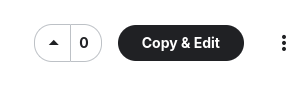
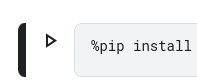

To run this notebook, as well as the others in this course, you will need to make a copy, or fork, the notebook. Look for the `Copy and Edit` button in the top-right, and **click it** to make an editable, private copy of the notebook. It should look like this one:

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

Your copy will now have a ▶️ **Run** button next to each code cell that you can press to execute that cell. These notebooks are expected to be run in order from top-to-bottom, but you are encouraged to add new cells, run your own code and explore. If you get stuck, you can try the `Factory reset` option in the `Run` menu, or head back to the original notebook and make a fresh copy.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

### Problems?

If you have any problems, head over to the [Kaggle Discord](https://discord.com/invite/kaggle), find the [`#5dgai-q-and-a` channel](https://discord.com/channels/1101210829807956100/1303438695143178251) and ask for help.

## Get started with the Gemini API

All of the exercises in this notebook will use the [Gemini API](https://ai.google.dev/gemini-api/) by way of the [Python SDK](https://pypi.org/project/google-genai/). Each of these prompts can be accessed directly in [Google AI Studio](https://aistudio.google.com/) too, so if you would rather use a web interface and skip the code for this activity, look for the <img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> AI Studio link on each prompt.

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_1.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_2.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_3.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_4.png)

### Install the SDK

In [82]:
!pip uninstall -qy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0"

Import the SDK and some helpers for rendering the output.

In [84]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [38]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [39]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
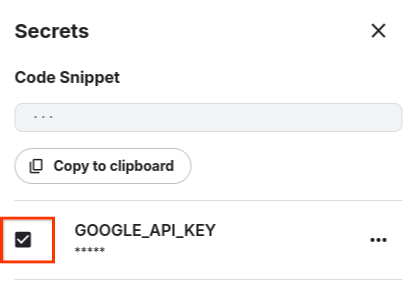

### Run your first prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [42]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Are you available to assist me today?. If yes, explain the top 10 concepts i must teach learn and apply when pre training LLM. Give me brief details about them")

print(response.text)

Yes, I am available to assist you today.

Okay, let's dive into the top 10 concepts to learn and apply when pre-training Large Language Models (LLMs):

**Top 10 Concepts for LLM Pre-training:**

1.  **Data Preprocessing and Cleaning:**
    *   **What:** The process of transforming raw text data into a format suitable for model training.  This involves cleaning, normalizing, and structuring the data.
    *   **Why:**  LLMs learn from the data they're trained on.  Dirty, inconsistent data leads to a poorly performing model.  High-quality data improves generalization and reduces bias.
    *   **Details:** Common techniques include:
        *   **Cleaning:** Removing HTML tags, special characters, irrelevant noise (e.g., excessive whitespace).
        *   **Normalization:** Lowercasing, stemming/lemmatization (reducing words to their root form), handling contractions.
        *   **Tokenization:** Breaking text into smaller units (words, sub-words) that the model can process.  Popular toke

The response often comes back in markdown format, which you can render directly in this notebook.

In [43]:
Markdown(response.text)

Yes, I am available to assist you today.

Okay, let's dive into the top 10 concepts to learn and apply when pre-training Large Language Models (LLMs):

**Top 10 Concepts for LLM Pre-training:**

1.  **Data Preprocessing and Cleaning:**
    *   **What:** The process of transforming raw text data into a format suitable for model training.  This involves cleaning, normalizing, and structuring the data.
    *   **Why:**  LLMs learn from the data they're trained on.  Dirty, inconsistent data leads to a poorly performing model.  High-quality data improves generalization and reduces bias.
    *   **Details:** Common techniques include:
        *   **Cleaning:** Removing HTML tags, special characters, irrelevant noise (e.g., excessive whitespace).
        *   **Normalization:** Lowercasing, stemming/lemmatization (reducing words to their root form), handling contractions.
        *   **Tokenization:** Breaking text into smaller units (words, sub-words) that the model can process.  Popular tokenizers include WordPiece, Byte Pair Encoding (BPE), and SentencePiece.
        *   **Data Deduplication:** Removing near-duplicate texts.
        *   **Filtering:** Removing texts based on quality measures (e.g. text length, perplexity).
2.  **Tokenization:**
    *   **What:** The process of converting text into numerical representations (tokens) that the LLM can understand.
    *   **Why:** LLMs work with numbers, not raw text.  The choice of tokenization method significantly impacts vocabulary size, training efficiency, and model performance.
    *   **Details:**
        *   **Word-level tokenization:** Simple but inefficient for large vocabularies.
        *   **Character-level tokenization:** Handles out-of-vocabulary words well but results in long sequences.
        *   **Subword tokenization (BPE, WordPiece, SentencePiece):** A compromise, breaking words into frequently occurring subword units. BPE is an iterative algorithm that merges frequent character or character sequence pairs. WordPiece uses a probability-based approach to select which subwords to merge. SentencePiece can treat the input text directly as a sequence of Unicode characters.
        *   **Vocabulary size:** Impacts model size and performance.  A larger vocabulary can represent more nuanced language but increases computational cost.

3.  **Masked Language Modeling (MLM):**
    *   **What:** A pre-training objective where the model is trained to predict masked words in a sentence.
    *   **Why:**  Forces the model to learn bidirectional contextual relationships between words.  Used effectively in models like BERT.
    *   **Details:**
        *   Randomly mask a percentage (e.g., 15%) of the tokens in the input sequence.
        *   The model predicts the original masked tokens based on the surrounding context.
        *   Loss function: Cross-entropy loss between the predicted and actual masked tokens.

4.  **Causal Language Modeling (CLM):**
    *   **What:**  A pre-training objective where the model is trained to predict the next word in a sequence, given the preceding words.  Also known as autoregressive language modeling.
    *   **Why:**  Learns unidirectional dependencies and is well-suited for text generation tasks.  Used in models like GPT.
    *   **Details:**
        *   The model receives a sequence of tokens as input and predicts the probability distribution of the next token.
        *   The model only attends to tokens *before* the current token (causal masking).
        *   Loss function: Cross-entropy loss between the predicted and actual next token.

5.  **Next Sentence Prediction (NSP):** (Less Common Now, but historically important)
    *   **What:**  A pre-training objective (originally used in BERT) where the model is trained to predict whether two given sentences are consecutive in a document.
    *   **Why:** Aims to improve the model's understanding of inter-sentence relationships.  However, its effectiveness has been debated, and it's often omitted in more recent pre-training approaches.
    *   **Details:**
        *   The model receives two sentences as input.
        *   The task is to predict whether the second sentence is the actual next sentence following the first sentence in the original text.
        *   50% of the time, the second sentence *is* the next sentence. The other 50% of the time, it's a random sentence from a different document.
        *   Loss function: Binary cross-entropy loss.

6.  **Attention Mechanisms (Self-Attention, Multi-Head Attention):**
    *   **What:**  A mechanism that allows the model to focus on the most relevant parts of the input sequence when processing each word. Self-attention relates different positions of a single input sequence in order to compute a representation of the sequence.  Multi-head attention allows the model to learn multiple attention patterns in parallel.
    *   **Why:**  Enables the model to capture long-range dependencies and contextual information effectively. It is fundamental to the Transformer architecture.
    *   **Details:**
        *   Calculate attention weights based on the similarity between each word and all other words in the sequence.
        *   Use these weights to create a weighted average of the input representations.
        *   Multi-head attention performs this process multiple times with different learned parameters, allowing the model to capture different aspects of the relationships between words.

7.  **Transformer Architecture:**
    *   **What:**  A neural network architecture based entirely on attention mechanisms.  It has become the dominant architecture for LLMs.
    *   **Why:**  Highly parallelizable, enabling efficient training on large datasets.  Effective at capturing long-range dependencies.
    *   **Details:**
        *   Consists of an encoder and a decoder (although some models use only the encoder or only the decoder).
        *   Key components:  Self-attention layers, feed-forward networks, residual connections, layer normalization.
        *   The encoder processes the input sequence, and the decoder generates the output sequence.

8.  **Scaling Laws:**
    *   **What:** Empirical relationships that describe how model performance improves with increases in model size, dataset size, and compute.
    *   **Why:**  Help predict the performance of larger models and optimize resource allocation during training.
    *   **Details:**
        *   Performance (e.g., loss) typically scales as a power law with model size, dataset size, and compute.
        *   These laws can be used to estimate the resources needed to achieve a desired level of performance.
        *   However, scaling laws are not perfect predictors and can be influenced by other factors, such as data quality and architecture.

9.  **Distributed Training and Optimization:**
    *   **What:** Techniques for training large models across multiple GPUs or machines.
    *   **Why:**  LLMs are too large to fit on a single GPU. Distributed training is essential for scaling up training.
    *   **Details:**
        *   **Data parallelism:** Distribute the training data across multiple GPUs. Each GPU processes a subset of the data and updates a copy of the model.
        *   **Model parallelism:** Partition the model across multiple GPUs. Each GPU stores and updates a portion of the model's parameters.
        *   **Tensor parallelism:** Partition individual tensor operations across multiple GPUs.
        *   **Pipeline parallelism:** Divide the layers of the model into stages, which are processed on different GPUs in a pipelined fashion.
        *   **Optimization:** Techniques like mixed-precision training (using both 16-bit and 32-bit floating-point numbers) can reduce memory usage and accelerate training.

10. **Evaluation Metrics:**
    *   **What:** Metrics used to assess the quality of the pre-trained language model.
    *   **Why:** Crucial for tracking progress during pre-training and comparing different models.
    *   **Details:**
        *   **Perplexity:** Measures how well the model predicts a held-out test set. Lower perplexity indicates better performance. (Common for CLM)
        *   **Masked Language Modeling Accuracy:** Measures the accuracy of predicting masked tokens. (Common for MLM)
        *   **Downstream task performance:** Evaluate the model on a variety of downstream tasks (e.g., text classification, question answering, summarization) to assess its generalization ability. Finetune the pre-trained model on these task-specific datasets and measure performance using appropriate metrics for each task.
        *   **Intrinsic Evaluation:** Evaluating on the language modeling task itself (perplexity, MLM accuracy).
        *   **Extrinsic Evaluation:** Evaluating on downstream tasks (classification, QA, etc.) after fine-tuning.

**Key Takeaways:**

*   **Data is King:** High-quality, diverse data is crucial for a successful LLM.
*   **Transformers are the Standard:** Understand the Transformer architecture and its attention mechanisms.
*   **Pre-training Objectives Matter:** Choose the right pre-training objective(s) based on your target applications.
*   **Scaling is Important:** Model size, data size, and compute are all critical factors.
*   **Evaluation is Essential:** Track performance during training and evaluate on downstream tasks.

This list provides a solid foundation for understanding LLM pre-training.  Remember that this field is constantly evolving, so continuous learning is key. Good luck!


### Start a chat

The previous example uses a single-turn, text-in/text-out structure, but you can also set up a multi-turn chat structure too.

In [44]:
chat = client.chats.create(model='gemini-2.0-flash', history=[])
response = chat.send_message('Hello! My name is Marimuthu.')
print(response.text)

Hello Marimuthu! It's nice to meet you. How can I help you today?



In [47]:
response = chat.send_message('I missed to print the response in Markdown format. So i am asking you again Yes. Can you tell me something about how best i can make LLM think using Chain of Thought prompting?. Can i use an LLM to even generate such thoughts?')
Markdown(response.text)

Okay, Marimuthu, I understand. Here's the previous response again, formatted in Markdown:

**What is Chain-of-Thought (CoT) Prompting?**

CoT is a prompting technique that encourages LLMs to break down complex problems into a series of smaller, more manageable steps. Instead of directly asking for the final answer, you guide the model to show its reasoning process. This typically leads to significantly improved accuracy, especially for tasks like:

*   **Arithmetic Reasoning:** Math problems with multiple steps.
*   **Commonsense Reasoning:** Questions that require real-world knowledge and inference.
*   **Symbolic Reasoning:** Tasks involving logic, planning, or code.

**How to Implement CoT Prompting:**

1.  **Demonstration (Few-Shot Learning):** This is the most common and effective approach. You provide the LLM with a few example questions *and* their corresponding step-by-step solutions. The LLM then learns to apply a similar reasoning process to your target question. Here's a template:

    ```
    Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
    A: Roger started with 5 balls.
    He bought 2 * 3 = 6 more balls.
    Now he has 5 + 6 = 11 balls.
    So the answer is 11.

    Q: The cafeteria had 23 apples. If they used 20 to make a pie and then bought 6 more, how many apples do they have?
    A: The cafeteria started with 23 apples.
    They used 20, so they had 23 - 20 = 3 apples left.
    Then they bought 6 more, so they have 3 + 6 = 9 apples.
    So the answer is 9.

    Q: Weng earns $12 an hour. Last week, he worked 7 hours on Monday, 4 hours on Tuesday, 4 hours on Wednesday, 5 hours on Thursday, and 5 hours on Friday. How much did Weng earn last week?
    A: Weng worked 7 + 4 + 4 + 5 + 5 = 25 hours.
    He earns $12 per hour, so he earned 25 * 12 = $300.
    So the answer is 300.

    Q: [Your Target Question Here]
    A:
    ```

    *   **Key Elements:**
        *   **Clear Problem Statement:** Present the question concisely.
        *   **Step-by-Step Reasoning:** Each line should represent a logical deduction or calculation.
        *   **"So the answer is..."**: Explicitly state the final answer. This helps the LLM learn the desired output format.
        *   **Variety:** Use a diverse set of examples that cover different aspects of the problem type. Don't just repeat the same logic with different numbers.
        *   **Consistency:** Maintain a consistent style and format across all examples.

2.  **Zero-Shot CoT (Using Hints):** You can sometimes encourage CoT reasoning without providing examples by simply adding a phrase to your prompt that hints at the need for step-by-step thinking. However, this is generally less effective than few-shot CoT.

    ```
    Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now? Let's think step by step.
    A:
    ```

    Other variations:

    *   "Let's work this out logically."
    *   "What are the intermediate steps?"
    *   "Let's reason through this."

**Using LLMs to Generate Chain-of-Thought Reasoning:**

Yes, this is a very useful technique! You can use a powerful LLM to generate the demonstrations (the example question-answer pairs with CoT reasoning) that you'll then use in your own CoT prompting. This is especially helpful if you need a large number of high-quality examples.

Here's how you can do it:

1.  **Define the Task and Problem Domain:** Clearly specify the type of problem you want the LLM to generate examples for (e.g., grade-school math word problems, logical puzzles, coding tasks).

2.  **Prompt Engineering for Example Generation:** Design a prompt that tells the LLM *exactly* how to create the examples. Here's a template:

    ```
    Your task is to generate examples of questions and their solutions, showing the reasoning process step-by-step. Each example should include a question (Q) and an answer (A) with a detailed chain-of-thought explanation.

    Format:

    Q: [Question Text]
    A: [Step 1: Reasoning step 1]
       [Step 2: Reasoning step 2]
       ...
       [Final Step: Calculation or deduction leading to the final answer]
       So the answer is [Final Answer].

    Example:

    Q: Sarah has 7 apples. John gives her 3 more. How many apples does Sarah have in total?
    A: Sarah starts with 7 apples.
       John gives her 3 more, so we add 3 to 7.
       7 + 3 = 10
       So the answer is 10.

    Now generate [Number] more examples of similar questions and their step-by-step solutions:
    ```

    *   **Key Elements:**
        *   **Clear Instructions:** Tell the LLM its specific task.
        *   **Desired Format:** Be very explicit about how the question and answer should be structured.
        *   **Example (One-Shot):** Providing a single example is often helpful to guide the LLM's style. Make sure your example is high-quality.
        *   **Number of Examples:** Specify how many examples you want the LLM to generate.

3.  **Refine and Filter the Generated Examples:** LLMs are not perfect. You'll need to carefully review the generated examples and filter out any that:

    *   Contain errors in logic or calculation.
    *   Lack a clear chain of thought.
    *   Are poorly worded or ambiguous.
    *   Are too similar to each other (you want diversity).

4.  **Use the Filtered Examples for CoT Prompting:** Once you have a set of good-quality, LLM-generated examples, you can use them in your few-shot CoT prompts, as described earlier.

**Tips for Better CoT Performance:**

*   **Start with a Strong Model:** More powerful LLMs (e.g., GPT-4, PaLM 2, Claude 3) tend to be better at CoT reasoning.
*   **Temperature Settings:** Experiment with the temperature setting. A lower temperature (e.g., 0.2-0.5) will make the LLM more deterministic and focused. A higher temperature (e.g., 0.7-0.9) can introduce more creativity and exploration, but also more errors. Generally, for CoT, you want a lower temperature to promote accuracy.
*   **Prompt Engineering is Key:** Spend time refining your prompts. Small changes in wording can have a significant impact on the LLM's performance.
*   **Test and Evaluate:** Thoroughly test your CoT prompts with a variety of questions and evaluate the accuracy of the answers.
*   **Consider Fine-Tuning:** For very specific tasks, fine-tuning an LLM on a dataset of CoT examples can significantly improve performance. However, this requires more data and resources.

**In Summary:**

CoT prompting is a powerful technique for improving the reasoning abilities of LLMs. By providing examples of step-by-step reasoning, you can guide the model to solve complex problems more accurately. You can even leverage LLMs themselves to generate those examples, saving you a lot of time and effort. Remember to carefully review and filter the generated examples to ensure their quality.

Let me know if you have any more questions.  Is there a specific part of this that you want me to clarify or give examples for?


While you have the `chat` object alive, the conversation state
persists. Confirm that by asking if it knows the user's name.

In [48]:
response = chat.send_message('Do you remember what my name is?')
print(response.text)

Yes, your name is Marimuthu.



### Choose a model

The Gemini API provides access to a number of models from the Gemini model family. Read about the available models and their capabilities on the [model overview page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this step you'll use the API to list all of the available models.

In [49]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking

The [`models.list`](https://ai.google.dev/api/models#method:-models.list) response also returns additional information about the model's capabilities, like the token limits and supported parameters.

In [50]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent', 'countTokens'],
 'tuned_model_info': {},
 'version': '2.0'}


## Explore generation parameters

#### Output length
#### Temperature - 'nudge's randomness
#### Top P

### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_output_tokens` parameter when using the Gemini API. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [62]:
from google.genai import types

short_config = types.GenerateContentConfig(max_output_tokens=200)#Limit the total output tokens the LLM is to generate

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Explain simply what is chain of thought prompting')

Markdown(response.text)

Chain-of-thought prompting is a technique where you encourage a large language model (like ChatGPT) to **think step-by-step** before giving you a final answer.

Instead of just asking a question, you ask it to **explain its reasoning process** out loud.

**Example:**

*   **Without Chain-of-Thought:**

    *   **Question:** The cafeteria had 23 apples. If they used 20 to make a pie and bought 6 more, how many apples do they have?
    *   **Model's Answer:** 9

*   **With Chain-of-Thought:**

    *   **Question:** The cafeteria had 23 apples. If they used 20 to make a pie and bought 6 more, how many apples do they have? Let's think step by step.
    *   **Model's Answer:** "First, the cafeteria had 23 apples.

In [63]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem about the car ownership costs vs public transportation costs in Zurich')

print(response.text)

A Zurich car, a gleaming pride,
But parking steep, where shall it hide?
Insurance, fuel, a constant drain,
A Freiheit bought, with monthly pain.

The tram bell rings, a cheerful sound,
For ZVV, efficiency bound.
A yearly pass, a frugal choice,
Leaving nature to rejoice.

So freedom's price, a costly thing,
While public transit lets you sing,
Through cobblestone streets, a steady ride,
Leaving ownership behind, with pride.



Explore with your own prompts. Try a prompt with a restrictive output limit and then adjust the prompt to work within that limit.

### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [64]:
high_temp_config = types.GenerateContentConfig(temperature=2.0)


for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=high_temp_config,
      contents='List some nice roads and street names which comforts family walking near Dubendorf in Zurich')

  if response.text:
    print(response.text, '-' * 25)

Okay, let's craft a list of pleasant-sounding and walking-friendly roads and streets near Dübendorf in Zurich, focusing on names that evoke tranquility, nature, or a sense of community.

**Key Considerations:**

*   **Proximity to Dübendorf:**  I'll focus on names within or near the town of Dübendorf or immediately adjacent neighborhoods.
*   **Likelihood of Being Walkable:**  I'll try to select names that suggest residential areas or areas with sidewalks and lower traffic.
*   **Elegance and Imagery:** Names that evokes beauty or some other emotions.

**Here's the list, categorized for clarity:**

**1. Nature-Inspired Names:**

*   **Im Grüene Plan:**  (Implies peaceful or natural fields)
*   **Rietwiesenstrasse:** ("Reed Meadow Street" evokes natural meadow).
*   **Im Rebberg:** ("In the Vineyard").
*   **Fliederweg:** (Lilac path) -  Evokes a flowering bush.
*   **Ahornweg:** (Maple way) - conjures big tree.

**2. Pleasant Adjectives and Locations:**

*   **Sonnenrain:** (Sunny Slop

Now try the same prompt with temperature set to zero. Note that the output is not completely deterministic, as other parameters affect token selection, but the results will tend to be more stable.

In [65]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='List some nice roads and street names which comforts family walking near Dubendorf in Zurich')

  if response.text:
    print(response.text, '-' * 25)

Okay, here are some nice road and street names near Dübendorf, Zurich, that evoke a sense of comfort and are suitable for a family walk, categorized for easier browsing:

**Nature-Inspired & Peaceful:**

*   **Waldstrasse (Forest Street):** A classic, suggesting a walk near or through a wooded area.
*   **Bachstrasse (Stream Street):** Implies a pleasant stroll alongside a small stream.
*   **Weiherweg (Pond Path):** Suggests a peaceful walk around a pond.
*   **Grüenistrasse (Green Street):** Evokes a sense of greenery and nature.
*   **Sonnenweg (Sun Path):** A sunny and cheerful walk.
*   **Blumenweg (Flower Path):** A path filled with flowers.
*   **Rebbergstrasse (Vineyard Street):** A walk through vineyards, often with beautiful views.

**Quiet & Residential:**

*   **Dorfstrasse (Village Street):** A classic, often found in older, quieter parts of towns.
*   **Gartenstrasse (Garden Street):** Suggests well-kept gardens and a peaceful atmosphere.
*   **Quartierstrasse (Neighborho

### Top-P

Like temperature, the top-P parameter is also used to control the diversity of the model's output.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

You may also see top-K referenced in LLM literature. Top-K is not configurable in the Gemini 2.0 series of models, but can be changed in older models. Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.


Run this example a number of times, change the settings and observe the change in output.

In [66]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a tortoiseshell tabby with eyes like melted amber, considered herself far too refined for adventure. Her days consisted of sunbathing on velvet cushions, delicately batting at dust motes, and judging the culinary choices of her human, Eleanor, with a discerning sniff. Adventure was messy, uncouth, and, frankly, beneath her.

Until the window was left ajar.

A symphony of scents – damp earth, blooming honeysuckle, and something tantalizingly fishy – drifted in, a siren song to a primal instinct Clementine usually kept well-buried. Curiosity, that pesky feline flaw, pricked at her. She stretched, yawned dramatically (just in case Eleanor was watching), and nonchalantly hopped onto the windowsill. One tentative paw, then another, and Clementine was outside.

The world exploded in a kaleidoscope of green and brown. Grass tickled her paws, butterflies flitted like living confetti, and a chorus of birds chirped a welcome she hadn't anticipated. Initially, Clementine remained clos

## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [67]:
model_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=1,
    max_output_tokens=5,
)

zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment: """

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

POSITIVE



#### Enum mode

The models are trained to generate text, and while the Gemini 2.0 models are great at following instructions, other models can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, but sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterwards. See [this prompt in AI Studio](https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g) for an example.

The Gemini API has an [Enum mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Enum.ipynb) feature that allows you to constrain the output to a fixed set of values.

In [68]:
import enum

class Sentiment(enum.Enum):
    POSITIVE = "positive"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

positive


When using constrained output like an enum, the Python SDK will attempt to convert the model's text response into a Python object automatically. It's stored in the `response.parsed` field.

In [69]:
enum_response = response.parsed
print(enum_response)
print(type(enum_response))

Sentiment.POSITIVE
<enum 'Sentiment'>


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1jjWkjUSoMXmLvMJ7IzADr_GxHPJVV2bg"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [70]:
few_shot_prompt = """Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "pepperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}
```

ORDER:
"""

customer_order = "Give me a large with cheese & pineapple"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, customer_order])

print(response.text)

```json
{
"size": "large",
"type": "normal",
"ingredients": ["cheese", "pineapple"]
}
```



#### JSON mode

To provide control over the schema, and to ensure that you only receive JSON (with no other text or markdown), you can use the Gemini API's [JSON mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb). This forces the model to constrain decoding, such that token selection is guided by the supplied schema.

In [71]:
import typing_extensions as typing

class PizzaOrder(typing.TypedDict):
    size: str
    ingredients: list[str]
    type: str


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=PizzaOrder,
    ),
    contents="Can I have a large dessert pizza with apple and chocolate")

print(response.text)

{
  "size": "large",
  "ingredients": ["apple", "chocolate"],
  "type": "dessert"
}


### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

Models like the Gemini family are trained to be "chatty" or "thoughtful" and will provide reasoning steps without prompting, so for this simple example you can ask the model to be more direct in the prompt to force a non-reasoning response. Try re-running this step if the model gets lucky and gets the answer correct on the first try.

In [72]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now, I
am 20 years old. How old is my partner? Return the answer directly."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

print(response.text)

52



Now try the same approach, but indicate to the model that it should "think step by step".

In [73]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now,
I am 20 years old. How old is my partner? Let's think step by step."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Here's how to solve this:

1.  **Find the age difference:** When you were 4, your partner was 3 times your age, meaning they were 4 * 3 = 12 years old.

2.  **Calculate the age difference:** The age difference between you and your partner is 12 - 4 = 8 years.

3.  **Determine partner's current age:** Since the age difference remains the same, your partner is currently 20 + 8 = 28 years old.

**Answer:** Your partner is currently 28 years old.


### ReAct: Reason and act

In this example you will run a ReAct prompt directly in the Gemini API and perform the searching steps yourself. As this prompt follows a well-defined structure, there are frameworks available that wrap the prompt into easier-to-use APIs that make tool calls automatically, such as the LangChain example from the "Prompting" whitepaper.

To try this out with the Wikipedia search engine, check out the [Searching Wikipedia with ReAct](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) cookbook example.


> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under an [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [74]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

To capture a single step at a time, while ignoring any hallucinated Observation steps, you will use `stop_sequences` to end the generation process. The steps are `Thought`, `Action`, `Observation`, in that order.

In [75]:
question = """Question
Who was the youngest author listed on the transformers NLP paper?
"""

# You will perform the Action; so generate up to, but not including, the Observation.
react_config = types.GenerateContentConfig(
    stop_sequences=["\nObservation"],
    system_instruction=model_instructions + example1 + example2,
)

# Create a chat that has the model instructions and examples pre-seeded.
react_chat = client.chats.create(
    model='gemini-2.0-flash',
    config=react_config,
)

resp = react_chat.send_message(question)
print(resp.text)

Thought 1
I need to find the transformers NLP paper and then look at the authors and find the youngest one.

Action 1
<search>transformers NLP paper</search>



Now you can perform this research yourself and supply it back to the model.

In [76]:
observation = """Observation 1
[1706.03762] Attention Is All You Need
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
"""
resp = react_chat.send_message(observation)
print(resp.text)

Thought 2
Now I have the authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. I need to find the youngest. I cannot determine this information from this context, so I will try searching for their ages. I'll start with Aidan N. Gomez.

Action 2
<search>Aidan N. Gomez age</search>



This process repeats until the `<finish>` action is reached. You can continue running this yourself if you like, or try the [Wikipedia example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) to see a fully automated ReAct system at work.

## Thinking mode

The experiemental Gemini Flash 2.0 "Thinking" model has been trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses.

Using a "thinking mode" model can provide you with high-quality responses without needing specialised prompting like the previous approaches. One reason this technique is effective is that you induce the model to generate relevant information ("brainstorming", or "thoughts") that is then used as part of the context in which the final response is generated.

Note that when you use the API, you get the final response from the model, but the thoughts are not captured. To see the intermediate thoughts, try out [the thinking mode model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-thinking-exp-01-21).

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1Z991SV7lZZZqioOiqIUPv9a9ix-ws4zk"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [77]:
import io
from IPython.display import Markdown, clear_output


response = client.models.generate_content_stream(
    model='gemini-2.0-flash-thinking-exp',
    contents='Who was the youngest author listed on the transformers NLP paper?',
)

buf = io.StringIO()
for chunk in response:
    buf.write(chunk.text)
    # Display the response as it is streamed
    print(chunk.text, end='')

# And then render the finished response as formatted markdown.
clear_output()
Markdown(buf.getvalue())

The youngest author listed on the "Attention is All You Need" paper (which introduced the Transformer architecture) is **Aidan N. Gomez**.

While precise birthdates for all authors are not readily available publicly, based on information like their educational backgrounds and career trajectories, Aidan N. Gomez is generally understood to be the youngest among the authors.  At the time of the paper's publication in 2017, he was likely in his early twenties and affiliated with the University of Toronto.

## Code prompting

### Generating code

The Gemini family of models can be used to generate code, configuration and scripts. Generating code can be helpful when learning to code, learning a new language or for rapidly generating a first draft.

It's important to be aware that since LLMs can make mistakes, and can repeat training data, it's essential to read and test your code first, and comply with any relevant licenses.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1YX71JGtzDjXQkgdes8bP6i3oH5lCRKxv"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [78]:
# The Gemini models love to talk, so it helps to specify they stick to the code if that
# is all that you want.
code_prompt = """
Write a Python function to calculate the factorial of a number. No explanation, provide only the code.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1,
        top_p=1,
        max_output_tokens=1024,
    ),
    contents=code_prompt)

Markdown(response.text)

```python
def factorial(n):
  """Calculates the factorial of a non-negative integer.

  Args:
    n: A non-negative integer.

  Returns:
    The factorial of n, or 1 if n is 0.
    Raises ValueError if n is negative.
  """
  if n < 0:
    raise ValueError("Factorial is not defined for negative numbers.")
  if n == 0:
    return 1
  else:
    result = 1
    for i in range(1, n + 1):
      result *= i
    return result
```

### Code execution

The Gemini API can automatically run generated code too, and will return the output.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/11veFr_VYEwBWcLkhNLr-maCG0G8sS_7Z"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [79]:
from pprint import pprint

config = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
)

code_exec_prompt = """
Generate the first 14 odd prime numbers, then calculate their sum.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=config,
    contents=code_exec_prompt)

for part in response.candidates[0].content.parts:
  pprint(part.to_json_dict())
  print("-----")

{'text': 'Okay, I can do that. First, I need to identify the first 14 odd '
         'prime numbers. Remember that a prime number is a number greater than '
         '1 that has no positive divisors other than 1 and itself. Odd prime '
         'numbers would exclude the number 2.\n'
         '\n'
         'Here are my thoughts:\n'
         '\n'
         '1.  List prime numbers starting from 3.\n'
         '2.  Exclude even numbers (they are not prime, except for 2).\n'
         '3.  Count the first 14 odd prime numbers.\n'
         '4.  Sum these 14 numbers.\n'
         '\n'
         "Now, let's generate the first 14 odd prime numbers and calculate "
         'their sum using a python code block.\n'
         '\n'}
-----
{'executable_code': {'code': 'primes = []\n'
                             'num = 3\n'
                             'count = 0\n'
                             '\n'
                             'while count < 14:\n'
                             '    is_prime = True\n'
  

This response contains multiple parts, including an opening and closing text part that represent regular responses, an `executable_code` part that represents generated code and a `code_execution_result` part that represents the results from running the generated code.

You can explore them individually.

In [80]:
for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

Okay, I can do that. First, I need to identify the first 14 odd prime numbers. Remember that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself. Odd prime numbers would exclude the number 2.

Here are my thoughts:

1.  List prime numbers starting from 3.
2.  Exclude even numbers (they are not prime, except for 2).
3.  Count the first 14 odd prime numbers.
4.  Sum these 14 numbers.

Now, let's generate the first 14 odd prime numbers and calculate their sum using a python code block.



```python
primes = []
num = 3
count = 0

while count < 14:
    is_prime = True
    for i in range(2, int(num**0.5) + 1):
        if num % i == 0:
            is_prime = False
            break
    if is_prime:
        primes.append(num)
        count += 1
    num += 2  # Only check odd numbers

print(f'{primes=}')

sum_of_primes = sum(primes)
print(f'{sum_of_primes=}')

```

```
primes=[3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_primes=326

```

The first 14 odd prime numbers are 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, and 47.

Their sum is 326.


### Explaining code

The Gemini family of models can explain code to you too. In this example, you pass a [bash script](https://github.com/magicmonty/bash-git-prompt) and ask some questions.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1N7LGzWzCYieyOf_7bAG4plrmkpDNmUyb"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [81]:
file_contents = !curl https://raw.githubusercontent.com/magicmonty/bash-git-prompt/refs/heads/master/gitprompt.sh

explain_prompt = f"""
Please explain what this file does at a very high level. What is it, and why would I use it?

```
{file_contents}
```
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=explain_prompt)

Markdown(response.text)

This file, `git-prompt.sh`, is a shell script designed to enhance your command-line prompt by displaying information about the Git repository you're currently working in.

**What it does:**

*   **Provides Git Status Information:** The core function is to analyze the current Git repository and display information such as the current branch, the status of tracked/untracked files, staged changes, the relationship with the remote repository (ahead, behind, etc.), and any conflicts.
*   **Customizable Prompt Appearance:** It allows you to customize the appearance of your prompt by using themes and color schemes. You can define your own colors and symbols to represent the different Git states.
*   **Asynchronous Operations:** It tries to perform some Git operations (like fetching remote information) asynchronously to avoid blocking the prompt and keep the terminal responsive.
*   **Virtual Environment Support:** It can detect and display the name of the active Python virtual environment (or `node_virtualenv` or `conda`).
*   **Configuration:** Uses `.bash-git-rc` to enable users to configure their prompt
*   **Cross-Shell Compatibility:** Aims to work with both Bash and Zsh shells.

**Why you would use it:**

*   **Improved Workflow:** Quickly see the status of your Git repository directly in your prompt, making it easier to track changes and avoid mistakes.
*   **Visual Cues:** The use of colors and symbols provides instant visual cues about the state of your repository.
*   **Customization:** Tailor the prompt to your personal preferences and workflow.
*   **Stay Informed:** Quickly identify if you have uncommitted changes, are behind the remote branch, or have merge conflicts.


## Learn more

To learn more about prompting in depth:

* Check out the whitepaper issued with today's content,
* Try out the apps listed at the top of this notebook ([TextFX](https://textfx.withgoogle.com/), [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) and [NotebookLM](https://notebooklm.google/)),
* Read the [Introduction to Prompting](https://ai.google.dev/gemini-api/docs/prompting-intro) from the Gemini API docs,
* Explore the Gemini API's [prompt gallery](https://ai.google.dev/gemini-api/prompts) and try them out in AI Studio,
* Check out the Gemini API cookbook for [inspirational examples](https://github.com/google-gemini/cookbook/blob/main/examples/) and [educational quickstarts](https://github.com/google-gemini/cookbook/blob/main/quickstarts/).

Be sure to check out the codelabs on day 3 too, where you will explore some more advanced prompting with code execution.

And please share anything exciting you have tried in the Discord!

*- [Mark McD](https://linktr.ee/markmcd)*